In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,5)
import seaborn as sns
import xgboost as xgb
import optuna

from mlxtend.plotting import plot_learning_curves
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score ,confusion_matrix


In [67]:
df = pd.read_csv('/content/winequality_kaggle.csv')
pd.set_option('display.max_columns', None)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [68]:
# creating a function which will give us features from the dataset
def data_feature(dataset):
    print("SHAPE OF THE DATA: ")
    print(dataset.shape)
    print("-"*90)
    print("INFORMATION OF THE DATA: ")
    print(dataset.info())
    print("-"*90)
    print("NUMBER OF NULL VALUES PRESENT IN THE DATA: ")
    print(dataset.isnull().sum())
    print("-"*90)
    print("COLUMN NAMES OF THE DATA: ")
    print(dataset.columns)
    print("-"*90)
    print("DATA TYPES OF THE DATA: ")
    print(dataset.dtypes)
    print("-"*90)
    
data_feature(df)


SHAPE OF THE DATA: 
(1599, 12)
------------------------------------------------------------------------------------------
INFORMATION OF THE DATA: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
m

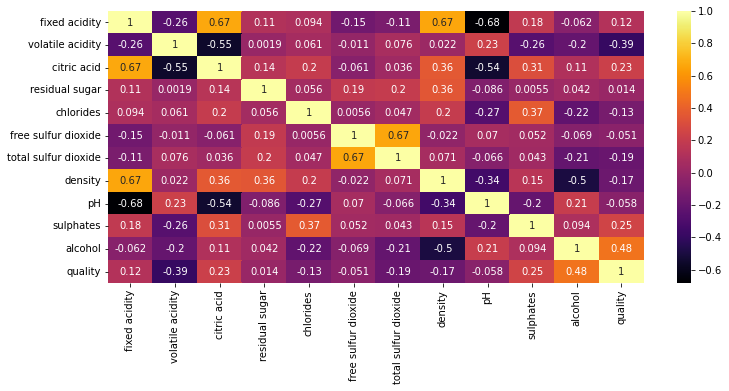

In [69]:
corr_data = df.corr()
sns.heatmap(df.corr(), annot=True, cmap='inferno');

In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [71]:
print(df['fixed acidity'].value_counts(dropna=False))
print("-"*90)
print(df['fixed acidity'].value_counts().nlargest(8))

7.2     67
7.1     57
7.8     53
7.5     52
7.0     50
        ..
13.5     1
13.8     1
13.4     1
4.7      1
5.5      1
Name: fixed acidity, Length: 96, dtype: int64
------------------------------------------------------------------------------------------
7.2    67
7.1    57
7.8    53
7.5    52
7.0    50
7.7    49
6.8    46
7.6    46
Name: fixed acidity, dtype: int64


In [72]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

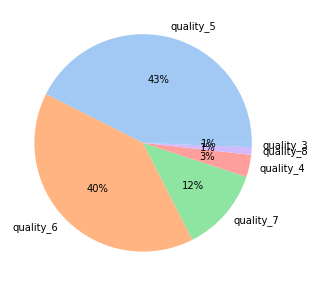

In [73]:
label  = ['quality_5','quality_6','quality_7','quality_4','quality_8','quality_3']
data = df['quality'].value_counts()
colors = sns.color_palette('pastel')[0:5]

plt.pie(data,labels=label,colors=colors,autopct='%.0f%%')
plt.show()

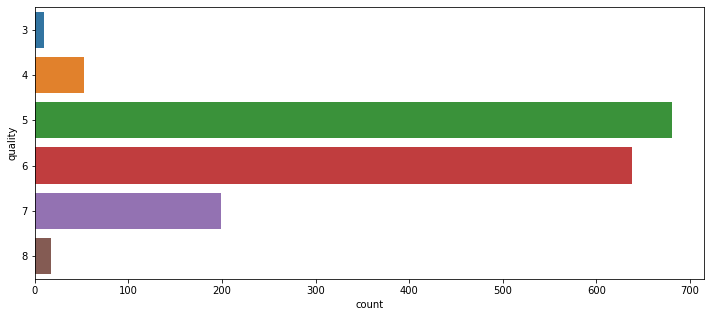

In [74]:
# countplot
sns.countplot(y=df['quality'])

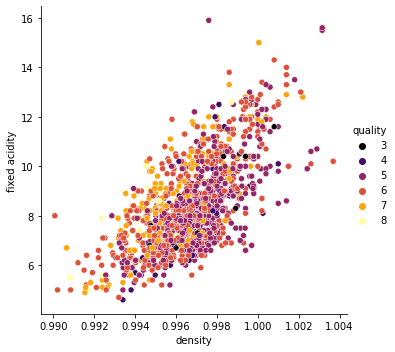

In [75]:
sns.relplot(x="density", y='fixed acidity', hue="quality" ,data=df,palette="inferno");

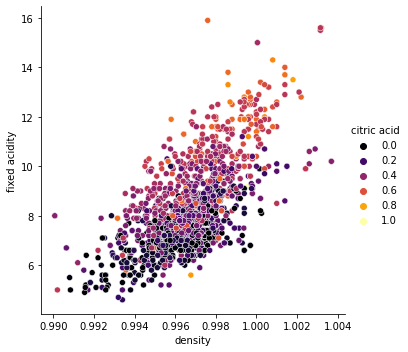

In [76]:
sns.relplot(x="density", y='fixed acidity', hue="citric acid" ,data=df ,palette="inferno");

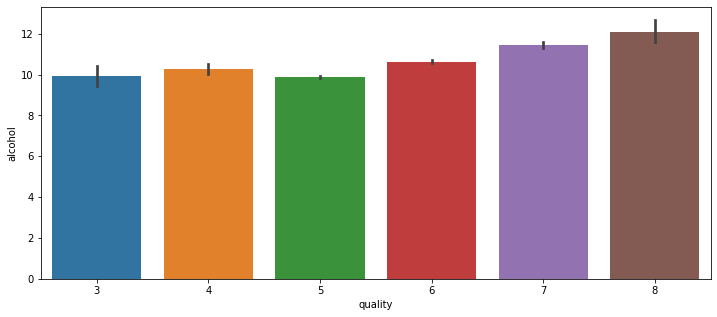

In [83]:
sns.barplot(data=df, x='quality', y="alcohol");

In [95]:
# Numerical variables :
num_cols = [c for c in df.columns if df[c].dtypes!='O']
print(num_cols)


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [96]:
# Data Splitting :
X = df.drop('quality',axis=1)
y = df['quality']

print(f' X_shape: {X.shape} \n y_shape: {y.shape}')

 X_shape: (1599, 11) 
 y_shape: (1599,)


In [97]:
# Feature Selection using Random Forest Importance :

rf_clf = RandomForestClassifier(criterion='entropy',n_estimators=20)
rfe_selector = RFE(estimator=rf_clf, n_features_to_select=6, step=10, verbose=5)
rfe_selector.fit(X, y)

Fitting estimator with 11 features.


RFE(estimator=RandomForestClassifier(criterion='entropy', n_estimators=20),
    n_features_to_select=6, step=10, verbose=5)

In [98]:
rfe_support = rfe_selector.get_support()

rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(rfe_feature)
print('*******************************************************************************************')
print(str(len(rfe_feature)), 'selected features')

['volatile acidity', 'citric acid', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
*******************************************************************************************
6 selected features


In [103]:
X  = df[rfe_feature]
y = df['quality']

print(f' X_shape: {X.shape} \n y_shape: {y.shape}')

 X_shape: (1599, 6) 
 y_shape: (1599,)


In [104]:
y.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [105]:
rs = RandomOverSampler()
X_resample, y_resample = rs.fit_resample(X,y)

print(f' Shape of X after Oversampling: {X_resample.shape} \n Shape of y after Oversampling: {y_resample.shape}')

 Shape of X after Oversampling: (4086, 6) 
 Shape of y after Oversampling: (4086,)


In [106]:
y_resample.value_counts()

5    681
6    681
7    681
4    681
8    681
3    681
Name: quality, dtype: int64

In [107]:
# Data Standardization :

from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
X_rescale = scl.fit_transform(X_resample)

In [108]:
# Data Splitting into train and test :

from sklearn.model_selection import train_test_split
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_rescale,y_resample,test_size=0.20,shuffle=True,random_state=0)
print(f' Shape of X_train: {X_train_res.shape} & Shape of X_test: {X_test_res.shape}')
print(f' Shape of y_train: {y_train_res.shape} & Shape of y_test: {y_test_res.shape}')

 Shape of X_train: (3268, 6) & Shape of X_test: (818, 6)
 Shape of y_train: (3268,) & Shape of y_test: (818,)


In [109]:
# RandomForest Classifier :

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train_res, y_train_res)
y_pred_test_res = rf_clf.predict(X_test_res)
y_pred_train_res = rf_clf.predict(X_train_res)

In [110]:
print('Accuracy score of Train after Oversampling: {}'.format(accuracy_score(y_train_res,y_pred_train_res)*100))
print('Accuracy score of Test after Oversampling: {}'.format(accuracy_score(y_test_res,y_pred_test_res)*100))

Accuracy score of Train after Oversampling: 100.0
Accuracy score of Test after Oversampling: 90.70904645476773


In [111]:
# Hyperparameter Tuning using optuna :

def objective(trial):
    param_grid = dict(
    criterion = trial.suggest_categorical('criterion', ['gini','entropy']),
    bootstrap = trial.suggest_categorical('bootstrap',['True','False']),
    max_depth = trial.suggest_int('max_depth', 1, 10000),
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']),
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000),
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    
                     )
    
    rf_clf = RandomForestClassifier(**param_grid)
    scores = cross_val_score(rf_clf, X_train_res, y_train_res, cv=5, scoring='accuracy')
    return scores.mean().round(5)

study = optuna.create_study(direction='maximize')


study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2022-06-15 15:51:13,272] A new study created in memory with name: no-name-8e52dbb1-93e0-4ea2-a2e9-613b3ea00b2d
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-15 15:51:25,289] Trial 0 finished with value: 0.89199 and parameters: {'criterion': 'gini', 'bootstrap': 'False', 'max_depth': 2117, 'max_features': 'auto', 'max_leaf_nodes': 996, 'n_estimators': 620}. Best is trial 0 with value: 0.89199.
[I 2022-06-15 15:51:39,354] Trial 1 finished with value: 0.89045 and parameters: {'criterion': 'gini', 'bootstrap': 'False', 'max_depth': 5768, 'max_features': 'log2', 'max_leaf_nodes': 8699, 'n_estimators': 712}. Best is trial 0 with value: 0.89199.
[I 2022-06-15 15:51:51,906] Trial 2 finished with value: 0.89106 and parameters: {'criterion': 'gini', 'bootstrap': 'False', 'max_depth': 487, 'max_features': 'log2', 'max_leaf_nodes': 9201, 'n_estimators': 635}. Best is trial 0 with value: 0.89199.
[I 2022-06-15 15:52:12,060] Trial 3 finished with value: 0.89045 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 2169, 'max_features': 'log2', 'max_leaf_nodes': 4621, 'n_estimators': 760}. Best is trial 0 with value: 0.891

In [112]:
best_params_rf = study.best_trial.params
print('Best parameters:', best_params_rf)
print('Best score: {:.2f}%'.format(study.best_value*100))

Best parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 2250, 'max_features': 'log2', 'max_leaf_nodes': 3226, 'n_estimators': 430}
Best score: 89.26%


In [113]:
rf_clf = RandomForestClassifier(**best_params_rf).fit(X_train_res,y_train_res)
y_pred_rf = rf_clf.predict(X_test_res)

In [114]:
print('Accuracy score of Test: ', accuracy_score(y_test_res, y_pred_rf)*100)

Accuracy score of Test:  90.83129584352079


In [115]:
print(confusion_matrix(y_test_res, y_pred_rf))

[[126   0   0   0   0   0]
 [  0 127   0   0   0   0]
 [  2   1 122  24   1   0]
 [  1   0  27 101  13   3]
 [  0   0   0   3 129   0]
 [  0   0   0   0   0 138]]


In [116]:
print(classification_report(y_test_res, y_pred_rf))

              precision    recall  f1-score   support

           3       0.98      1.00      0.99       126
           4       0.99      1.00      1.00       127
           5       0.82      0.81      0.82       150
           6       0.79      0.70      0.74       145
           7       0.90      0.98      0.94       132
           8       0.98      1.00      0.99       138

    accuracy                           0.91       818
   macro avg       0.91      0.91      0.91       818
weighted avg       0.91      0.91      0.91       818



In [121]:
# XGB Classifier :
# Encoding  the quality [3->0,4->1,5->2,6->3,7->4,8->5]

y_train_res  = np.unique(y_train_res, return_inverse = True)[1] 
print(np.unique(y_train_res))

[0 1 2 3 4 5]


In [122]:
y_train_res

array([1, 5, 5, ..., 0, 1, 1])

In [123]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 0, 300)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.1, 0.3, 0.01)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)

    xgboost_clf = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42, 
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        subsample = subsample,
        learning_rate=learning_rate,
        colsample_bytree = colsample_bytree
    )

    scores = cross_val_score(xgboost_clf, X_train_res, y_train_res, cv=5, scoring='accuracy')
    return scores.mean().round(5)

study = optuna.create_study(direction='maximize')


study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2022-06-15 16:01:58,115] A new study created in memory with name: no-name-1db0276a-8bb7-4a6b-b139-5bc77165d5dc
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-15 16:02:00,754] Trial 0 finished with value: 0.77969 and parameters: {'n_estimators': 103, 'max_depth': 2, 'min_child_weight': 7, 'learning_rate': 0.18, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.77969.
[I 2022-06-15 16:02:02,071] Trial 1 finished with value: 0.75674 and parameters: {'n_estimators': 63, 'max_depth': 2, 'min_child_weight': 16, 'learning_rate': 0.24000000000000002, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.77969.
[I 2022-06-15 16:02:10,610] Trial 2 finished with value: 0.88066 and parameters: {'n_estimators': 196, 'max_depth': 19, 'min_child_weight': 8, 'learning_rate': 0.13, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 2 with value: 0.88066.
[I 2022-06-15 16:02:18,209] Trial 3 finished with value: 0.85894 and parameters: {'n_estimators': 232, 'max_depth': 5, 'min_child_weight': 20, 'learning_rate': 0.28, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 2 with value: 0.88066.

In [124]:
best_params_xgb = study.best_trial.params
print('Best parameters:', best_params_xgb)
print('Best score: {:.2f}%'.format(study.best_value*100))

Best parameters: {'n_estimators': 135, 'max_depth': 11, 'min_child_weight': 1, 'learning_rate': 0.19, 'subsample': 0.7, 'colsample_bytree': 0.8}
Best score: 89.26%


In [125]:
xgb_clf = xgb.XGBClassifier(**best_params_xgb).fit(X_train_res,y_train_res)
y_pred_xgb = xgb_clf.predict(X_test_res)

In [126]:
y_test_res_xgb = np.unique(y_test_res, return_inverse = True)[1] # to encode quality

In [127]:
print('Accuracy score of Test: ', accuracy_score(y_test_res_xgb, y_pred_xgb)*100)

Accuracy score of Test:  89.73105134474328


In [128]:
print(classification_report(y_test_res_xgb, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       126
           1       1.00      1.00      1.00       127
           2       0.81      0.76      0.78       150
           3       0.75      0.69      0.72       145
           4       0.90      0.98      0.94       132
           5       0.98      1.00      0.99       138

    accuracy                           0.90       818
   macro avg       0.90      0.90      0.90       818
weighted avg       0.89      0.90      0.89       818



In [129]:
# LGBM Classifier :

def objective(trial):
    param_grid = dict(n_estimators=trial.suggest_int('n_estimators', 20, 1000, 10), 
                      learning_rate=trial.suggest_float('learning_rate', 0, 1), 
                      max_depth=trial.suggest_int('max_depth', 3, 12))
    clf = LGBMClassifier(**param_grid)
    scores = cross_val_score(clf, X_train_res, y_train_res, cv=5, scoring='accuracy')
    return scores.mean().round(5)

study = optuna.create_study(direction='maximize')


study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2022-06-15 16:03:56,092] A new study created in memory with name: no-name-3752e304-d80f-49d8-bb94-50cd1f03d93c
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-15 16:04:01,383] Trial 0 finished with value: 0.89168 and parameters: {'n_estimators': 250, 'learning_rate': 0.3131716080068413, 'max_depth': 9}. Best is trial 0 with value: 0.89168.
[I 2022-06-15 16:04:06,259] Trial 1 finished with value: 0.88862 and parameters: {'n_estimators': 500, 'learning_rate': 0.8229352948477289, 'max_depth': 5}. Best is trial 0 with value: 0.89168.
[I 2022-06-15 16:04:12,494] Trial 2 finished with value: 0.89168 and parameters: {'n_estimators': 760, 'learning_rate': 0.8825267338429799, 'max_depth': 6}. Best is trial 0 with value: 0.89168.
[I 2022-06-15 16:04:14,709] Trial 3 finished with value: 0.89291 and parameters: {'n_estimators': 100, 'learning_rate': 0.6957554306185878, 'max_depth': 11}. Best is trial 3 with value: 0.89291.
[I 2022-06-15 16:04:19,314] Trial 4 finished with value: 0.89168 and parameters: {'n_estimators': 320, 'learning_rate': 0.5291641303369807, 'max_depth': 7}. Best is trial 3 with value: 0.89291.
[I 2022-06-15 16:04:26,279] T

In [130]:
best_params_lgb = study.best_trial.params
print('Best parameters:', best_params_lgb)
print('Best score: {:.2f}%'.format(study.best_value*100))

Best parameters: {'n_estimators': 100, 'learning_rate': 0.6957554306185878, 'max_depth': 11}
Best score: 89.29%


In [131]:
lgb_clf = LGBMClassifier(**best_params_lgb).fit(X_train_res,y_train_res)
y_pred_lgb = lgb_clf.predict(X_test_res)

In [132]:
y_test_res_lgb = np.unique(y_test_res, return_inverse = True)[1] 

In [133]:
print('Accuracy score of Test: ', accuracy_score(y_test_res_lgb, y_pred_lgb)*100)

Accuracy score of Test:  90.2200488997555


In [134]:
print(classification_report(y_test_res_lgb, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       126
           1       1.00      1.00      1.00       127
           2       0.80      0.81      0.80       150
           3       0.78      0.67      0.72       145
           4       0.89      0.98      0.93       132
           5       0.99      1.00      0.99       138

    accuracy                           0.90       818
   macro avg       0.90      0.91      0.91       818
weighted avg       0.90      0.90      0.90       818



In [135]:
# Voting Classifier :

voting_clf = VotingClassifier([('rf',rf_clf),('xgb',xgb_clf),('lgb',lgb_clf)],verbose=True)
voting_clf.fit(X_train_res,y_train_res)
voting_clf_results = cross_val_score(estimator = voting_clf, X = X_train_res, y = y_train_res, cv = 5)
voting_clf_pred = voting_clf.predict(X_test_res)

[Voting] ....................... (1 of 3) Processing rf, total=   1.8s
[Voting] ...................... (2 of 3) Processing xgb, total=   1.9s
[Voting] ...................... (3 of 3) Processing lgb, total=   0.5s
[Voting] ....................... (1 of 3) Processing rf, total=   1.6s
[Voting] ...................... (2 of 3) Processing xgb, total=   1.5s
[Voting] ...................... (3 of 3) Processing lgb, total=   0.4s
[Voting] ....................... (1 of 3) Processing rf, total=   1.6s
[Voting] ...................... (2 of 3) Processing xgb, total=   1.5s
[Voting] ...................... (3 of 3) Processing lgb, total=   0.4s
[Voting] ....................... (1 of 3) Processing rf, total=   1.6s
[Voting] ...................... (2 of 3) Processing xgb, total=   1.5s
[Voting] ...................... (3 of 3) Processing lgb, total=   0.4s
[Voting] ....................... (1 of 3) Processing rf, total=   1.5s
[Voting] ...................... (2 of 3) Processing xgb, total=   1.5s
[Votin

In [136]:
y_test_res_voting = np.unique(y_test_res, return_inverse = True)[1] 
print('Accuracy score of Test: {}'.format(accuracy_score(y_test_res_voting,voting_clf_pred)*100))

Accuracy score of Test: 90.34229828850856


In [137]:
print(confusion_matrix(y_test_res_voting, voting_clf_pred))

[[126   0   0   0   0   0]
 [  0 127   0   0   0   0]
 [  2   0 119  27   2   0]
 [  3   0  26 100  13   3]
 [  0   0   0   3 129   0]
 [  0   0   0   0   0 138]]


In [139]:
print(classification_report(y_test_res_voting, voting_clf_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       126
           1       1.00      1.00      1.00       127
           2       0.82      0.79      0.81       150
           3       0.77      0.69      0.73       145
           4       0.90      0.98      0.93       132
           5       0.98      1.00      0.99       138

    accuracy                           0.90       818
   macro avg       0.90      0.91      0.91       818
weighted avg       0.90      0.90      0.90       818



In [140]:
rf = accuracy_score(y_test_res,y_pred_rf)*100
xgb = accuracy_score(y_test_res_xgb,y_pred_xgb)*100
lgb = accuracy_score(y_test_res_lgb,y_pred_lgb)*100
voting = accuracy_score(y_test_res_voting,voting_clf_pred)*100

scores = [rf,xgb,lgb,voting]
labels = ['Random Forest Classifier', 'XGB Classifier','LGB Classifier', 'Voting Classifier']
accs = {'Accuracy': scores}
df = pd.DataFrame(accs,index=labels)
df

,Accuracy
Random Forest Classifier,90.831296
XGB Classifier,89.731051
LGB Classifier,90.220049
Voting Classifier,90.342298


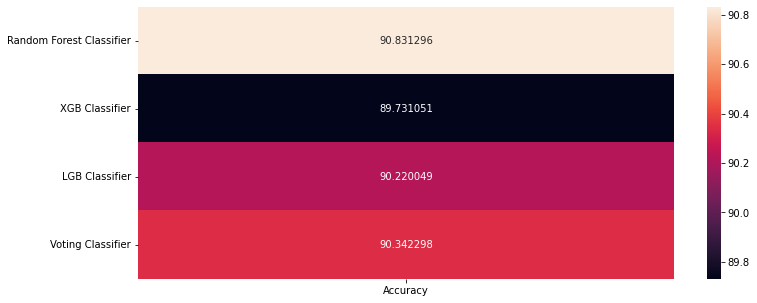

In [141]:
ax = sns.heatmap(df,annot=True,fmt="1f")

In [144]:
# Building a Predictive System :

input_data = (0.77,0.34,77,0.82,0.46,8.7)

# changing the input data to a numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the data as we are predicting the label for only one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = rf_clf.predict(input_data_reshaped)
print(prediction)

if (prediction[0]==1):
  print('Good Quality Wine')
else:
  print('Bad Quality Wine')

[5]
Bad Quality Wine
